In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import numpy as np
import pyro
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import pyro.distributions as dist

In [2]:
device = torch.device("cpu")

In [3]:
class PyroLinear(pyro.nn.PyroModule):
    def __init__(self, in_features, out_features, prior_var):
        super().__init__()
        self.linear = pyro.nn.PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = pyro.nn.PyroSample(dist.Normal(0.0, prior_var).expand((out_features, in_features)).to_event(2))
        self.linear.bias = pyro.nn.PyroSample(dist.Normal(0.0, prior_var).expand((out_features,)).to_event(1))

    def forward(self, x):
        return self.linear(x)

In [4]:
class PyroVIModule(pyro.nn.PyroModule):
    def __init__(self, layers, noise=None):
        super().__init__()
        self.model = layers
        self.noise = noise
        self.losses = []

    def _model(self, x, y=None):
        if self.noise is None:
            noise = pyro.sample("noise", dist.Uniform(0.0, 10.0))
        else:
            noise = self.noise
        mean = self.model(x)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, noise).to_event(1), obs=y)
        return mean

    def train_model(self, epochs, loader, batch_size, device, report_every_epochs=1):
        self.model.to(device)
        self.model.train()

        self.guide = pyro.infer.autoguide.AutoMultivariateNormal(self._model)
        optimizer = pyro.optim.Adam({"lr": 0.001})
        svi = pyro.infer.SVI(self._model, self.guide, optimizer, loss=pyro.infer.Trace_ELBO())
        pyro.clear_param_store()

        for epoch in range(epochs):
            epoch_loss = torch.tensor(0, dtype=torch.float)
            for data, target in loader:
                loss = svi.step(data, target)
                epoch_loss += loss
            epoch_loss /= (len(loader) * batch_size)
            self.losses.append(epoch_loss.detach())
            if report_every_epochs > 0 and epoch % report_every_epochs == 0:
                print(f"Epoch {epoch}: loss {epoch_loss}")
        if report_every_epochs >= 0:
            print(f"Final loss {epoch_loss}")
    
    def all_losses(self):
        return [self.losses]

    def infer(self, input, samples):
        predictive = pyro.infer.Predictive(self._model, guide=self.guide, num_samples=samples)
        output = predictive(input)["obs"]
        return torch.stack((output, self.noise.expand(output.shape)), -1)

In [5]:
from experiments.toy_regression import gap_datasets, plot_grid, NOISE
torch.manual_seed(42)

dataset, trainloader, testset = gap_datasets(device)

model = PyroVIModule(pyro.nn.PyroModule[nn.Sequential](
    PyroLinear(1, 32, 1),
    pyro.nn.PyroModule[nn.ReLU](),
    PyroLinear(32, 32, 1),
    pyro.nn.PyroModule[nn.ReLU](),
    PyroLinear(32, 1, 1)
), NOISE)
model.train_model(1000, trainloader, 20, device, report_every_epochs=10)

Epoch 0: loss 1990.17041015625
Epoch 10: loss 1406.6004638671875
Epoch 20: loss 1483.6383056640625
Epoch 30: loss 1209.729736328125
Epoch 40: loss 1828.8759765625
Epoch 50: loss 1873.7510986328125
Epoch 60: loss 1031.9383544921875
Epoch 70: loss 1288.21826171875
Epoch 80: loss 1077.7730712890625
Epoch 90: loss 1153.107421875
Epoch 100: loss 1255.795166015625
Epoch 110: loss 1249.505859375
Epoch 120: loss 1253.411376953125
Epoch 130: loss 856.1490478515625
Epoch 140: loss 1106.2203369140625
Epoch 150: loss 713.6622924804688
Epoch 160: loss 953.3186645507812
Epoch 170: loss 1083.822509765625
Epoch 180: loss 757.167236328125
Epoch 190: loss 972.6204833984375
Epoch 200: loss 715.3739013671875
Epoch 210: loss 993.7586669921875
Epoch 220: loss 585.5304565429688
Epoch 230: loss 579.831787109375
Epoch 240: loss 625.6365356445312
Epoch 250: loss 423.63543701171875
Epoch 260: loss 641.9840698242188
Epoch 270: loss 536.6949462890625
Epoch 280: loss 588.5050659179688
Epoch 290: loss 418.9312133789

In [6]:
pyro.get_param_store().save("trained_models/toy/regression/frvi_pyro.save")

In [7]:
pyro.get_param_store().load("trained_models/toy/regression/frvi_pyro.save")

In [ ]:
plot_grid(dataset, testset, [("VI", model, 1000)], device, plot_ground_truth=False)

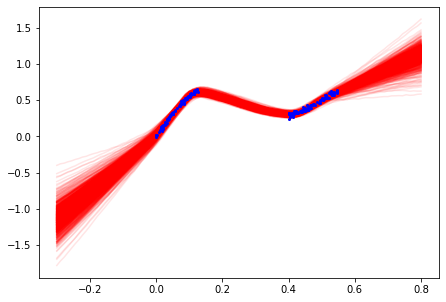

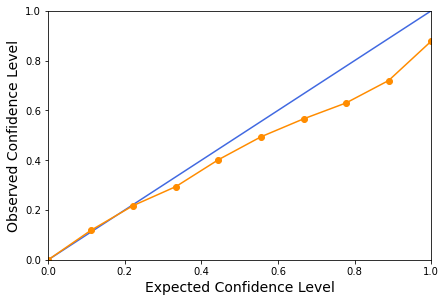

In [8]:
from experiments.toy_regression import store_results

store_results(dataset, testset, [("full_vi", model, 1000)], device, plot_ground_truth=False)

In [31]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).shape)

guide.loc torch.Size([1153])
guide.scale torch.Size([1153])
guide.scale_tril torch.Size([1153, 1153])
